In [144]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import History
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import sigmoid_kernel

In [145]:
# Load product file
product = pd.read_excel('_nosh_product_data.xlsx')
product

,product_id,product,shelf_life,usual_storage,calories,serving_size_g,fat_total_g,fat_saturated_g,protein_g,sodium_mg,potassium_mg,cholesterol_mg,carbohydrates_total_g,fiber_g,sugar_g
0,1,spaghetti,430,pantry,154.1,100,0.6,0.1,5.3,4,75,0,30.6,1.3,1.1
1,2,onion,13,pantry,44.7,100,0.2,0.0,1.4,2,35,0,10.1,1.4,4.7
2,3,sugar,360,pantry,385.6,100,0.0,0.0,0.0,0,0,0,99.8,0.0,100.1
3,4,mustard,60,pantry,58.3,100,3.4,0.2,3.8,1125,106,0,5.7,4.0,1.0
4,5,tomato sauce,285,pantry,24.6,100,0.3,0.0,1.2,472,26,0,5.4,1.5,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,206,cooked broccoli,7,fridge,35.0,100,0.4,0.1,2.4,41,65,0,7.3,3.3,1.4
206,207,mushroom,7,fridge,28.0,100,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3
207,208,cooked mushroom,7,fridge,28.0,100,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3
208,209,sliced mushroom,5,fridge,28.0,100,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3


In [146]:
product_df = product.drop(["product","usual_storage","product_id","shelf_life","serving_size_g"],axis=1)

In [147]:
product_df.reset_index(inplace = True, drop = True)
product_df

,calories,fat_total_g,fat_saturated_g,protein_g,sodium_mg,potassium_mg,cholesterol_mg,carbohydrates_total_g,fiber_g,sugar_g
0,154.1,0.6,0.1,5.3,4,75,0,30.6,1.3,1.1
1,44.7,0.2,0.0,1.4,2,35,0,10.1,1.4,4.7
2,385.6,0.0,0.0,0.0,0,0,0,99.8,0.0,100.1
3,58.3,3.4,0.2,3.8,1125,106,0,5.7,4.0,1.0
4,24.6,0.3,0.0,1.2,472,26,0,5.4,1.5,3.6
...,...,...,...,...,...,...,...,...,...,...
205,35.0,0.4,0.1,2.4,41,65,0,7.3,3.3,1.4
206,28.0,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3
207,28.0,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3
208,28.0,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3


In [148]:
product_df.describe()

,calories,fat_total_g,fat_saturated_g,protein_g,sodium_mg,potassium_mg,cholesterol_mg,carbohydrates_total_g,fiber_g,sugar_g
count,210.000000,210.000000,210.000000,210.000000,210.00000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,209.315714,10.918571,3.499048,8.105238,433.80000,137.366667,19.385714,22.203810,3.395238,7.832857
std,186.996437,18.751214,8.148819,9.302658,2684.34383,156.979912,43.966699,24.538781,7.035160,18.027266
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.000000,0.300000,0.000000,0.900000,3.00000,23.000000,0.000000,3.625000,0.000000,0.100000
50%,154.950000,1.000000,0.200000,3.700000,40.50000,70.000000,0.000000,13.150000,1.500000,1.450000
75%,302.975000,15.450000,3.850000,12.200000,372.75000,203.500000,2.000000,31.125000,3.075000,4.975000
max,883.000000,101.200000,81.000000,40.400000,38395.00000,638.000000,371.000000,99.800000,53.800000,100.100000


In [149]:
product_df.corr()

,calories,fat_total_g,fat_saturated_g,protein_g,sodium_mg,potassium_mg,cholesterol_mg,carbohydrates_total_g,fiber_g,sugar_g
calories,1.000000,0.867622,0.594455,0.434963,-0.044744,0.556178,0.226765,0.331343,0.155390,0.201541
fat_total_g,0.867622,1.000000,0.687760,0.335875,-0.007726,0.412684,0.283508,-0.109722,0.002553,-0.037632
fat_saturated_g,0.594455,0.687760,1.000000,0.246839,-0.001618,0.271854,0.430500,-0.136876,-0.074291,-0.034068
protein_g,0.434963,0.335875,0.246839,1.000000,-0.012244,0.796857,0.517866,-0.125806,0.114589,-0.228141
sodium_mg,-0.044744,-0.007726,-0.001618,-0.012244,1.000000,-0.000028,-0.000480,-0.078878,-0.050704,-0.051523
potassium_mg,0.556178,0.412684,0.271854,0.796857,-0.000028,1.000000,0.319107,0.081398,0.214334,-0.169895
cholesterol_mg,0.226765,0.283508,0.430500,0.517866,-0.000480,0.319107,1.000000,-0.309815,-0.205981,-0.125972
carbohydrates_total_g,0.331343,-0.109722,-0.136876,-0.125806,-0.078878,0.081398,-0.309815,1.000000,0.413999,0.655328
fiber_g,0.155390,0.002553,-0.074291,0.114589,-0.050704,0.214334,-0.205981,0.413999,1.000000,-0.009101
sugar_g,0.201541,-0.037632,-0.034068,-0.228141,-0.051523,-0.169895,-0.125972,0.655328,-0.009101,1.000000


<AxesSubplot:>

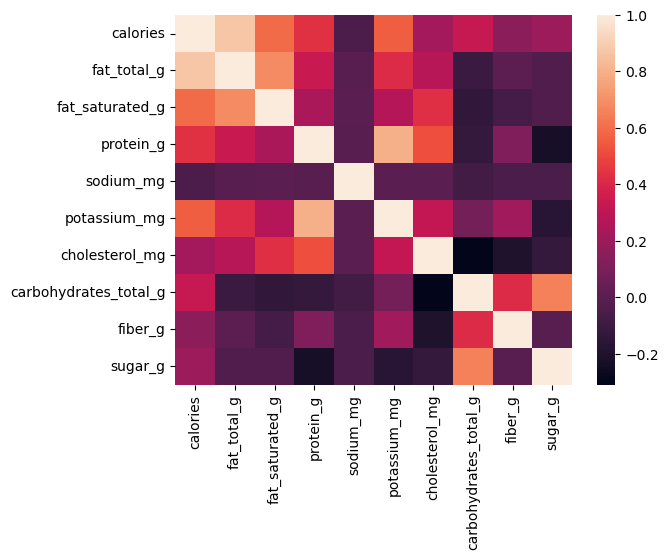

In [150]:
sns.heatmap(product_df.corr())

In [151]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


     

corr_features = correlation(product_df, 0.70)
len(set(corr_features))

corr_features

{'fat_total_g', 'potassium_mg'}

In [152]:
product_df

,calories,fat_total_g,fat_saturated_g,protein_g,sodium_mg,potassium_mg,cholesterol_mg,carbohydrates_total_g,fiber_g,sugar_g
0,154.1,0.6,0.1,5.3,4,75,0,30.6,1.3,1.1
1,44.7,0.2,0.0,1.4,2,35,0,10.1,1.4,4.7
2,385.6,0.0,0.0,0.0,0,0,0,99.8,0.0,100.1
3,58.3,3.4,0.2,3.8,1125,106,0,5.7,4.0,1.0
4,24.6,0.3,0.0,1.2,472,26,0,5.4,1.5,3.6
...,...,...,...,...,...,...,...,...,...,...
205,35.0,0.4,0.1,2.4,41,65,0,7.3,3.3,1.4
206,28.0,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3
207,28.0,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3
208,28.0,0.5,0.1,2.1,1,87,0,5.3,2.1,2.3


In [153]:
product_df = product_df.drop(["fat_total_g","cholesterol_mg"],axis=1)
product_df

,calories,fat_saturated_g,protein_g,sodium_mg,potassium_mg,carbohydrates_total_g,fiber_g,sugar_g
0,154.1,0.1,5.3,4,75,30.6,1.3,1.1
1,44.7,0.0,1.4,2,35,10.1,1.4,4.7
2,385.6,0.0,0.0,0,0,99.8,0.0,100.1
3,58.3,0.2,3.8,1125,106,5.7,4.0,1.0
4,24.6,0.0,1.2,472,26,5.4,1.5,3.6
...,...,...,...,...,...,...,...,...
205,35.0,0.1,2.4,41,65,7.3,3.3,1.4
206,28.0,0.1,2.1,1,87,5.3,2.1,2.3
207,28.0,0.1,2.1,1,87,5.3,2.1,2.3
208,28.0,0.1,2.1,1,87,5.3,2.1,2.3


In [154]:
scaler = MinMaxScaler()
product_df = scaler.fit_transform(product_df)

In [155]:
product_df

array([[0.17451869, 0.00123457, 0.13118812, ..., 0.30661323, 0.02416357,
        0.01098901],
       [0.05062288, 0.        , 0.03465347, ..., 0.1012024 , 0.0260223 ,
        0.04695305],
       [0.43669309, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.03171008, 0.00123457, 0.0519802 , ..., 0.05310621, 0.03903346,
        0.02297702],
       [0.03171008, 0.00123457, 0.0519802 , ..., 0.05310621, 0.03903346,
        0.02297702],
       [0.32955832, 0.0037037 , 0.23514851, ..., 0.74148297, 0.21189591,
        0.02197802]])

In [156]:
product_df.shape

(210, 8)

In [157]:

history = History()
# Define encoder model

def build(training=True):
    input_layer = Input(shape=(product_df.shape[1],))
    encoder_layer = Dense(256, activation='relu')(input_layer)
    encoder_layer = Dropout(0.2)(encoder_layer)
    encoder_layer = Dense(128, activation='relu')(encoder_layer)
    encoder_layer = Dropout(0.2)(encoder_layer)
    encoder_layer = Dense(64, activation='relu')(encoder_layer)
    encoded = Dense(32, activation='sigmoid')(encoder_layer)

    # Define decoder model
    decoder_layer = Dense(64, activation='relu')(encoded)
    decoder_layer = Dropout(0.2)(decoder_layer)
    decoder_layer = Dense(128, activation='relu')(decoder_layer)
    decoder_layer = Dropout(0.2)(decoder_layer)
    decoder_layer = Dense(256, activation='relu')(decoder_layer)
    decoded = Dense(product_df.shape[1], activation='sigmoid')(decoder_layer)

    # Define encoder-decoder model
    if training:
        autoencoder = Model(input_layer, decoded)
    else:
        autoencoder = Model(input_layer, encoded)
    return autoencoder

autoencoder = build(training=True)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])

autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_104 (Dense)           (None, 256)               2304      
                                                                 
 dropout_52 (Dropout)        (None, 256)               0         
                                                                 
 dense_105 (Dense)           (None, 128)               32896     
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_106 (Dense)           (None, 64)                8256      
                                                                 
 dense_107 (Dense)           (None, 32)                208

c:\Users\Aai\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [158]:
# Train encoder-decoder model
autoencoder.fit(product_df, product_df, epochs=100, batch_size=128,validation_split=0.33,callbacks=[history])

autoencoder.save_weights("output.h5")

Epoch 1/100
2/2 [==============================] - 1s 122ms/step - loss: 0.6700 - accuracy: 0.2429 - val_loss: 0.6035 - val_accuracy: 0.1571
Epoch 2/100
2/2 [==============================] - 0s 23ms/step - loss: 0.6098 - accuracy: 0.2000 - val_loss: 0.5433 - val_accuracy: 0.1571
Epoch 3/100
2/2 [==============================] - 0s 22ms/step - loss: 0.5555 - accuracy: 0.1857 - val_loss: 0.4800 - val_accuracy: 0.1571
Epoch 4/100
2/2 [==============================] - 0s 21ms/step - loss: 0.5003 - accuracy: 0.1643 - val_loss: 0.4187 - val_accuracy: 0.1571
Epoch 5/100
2/2 [==============================] - 0s 22ms/step - loss: 0.4535 - accuracy: 0.1286 - val_loss: 0.3677 - val_accuracy: 0.1571
Epoch 6/100
2/2 [==============================] - 0s 18ms/step - loss: 0.4209 - accuracy: 0.1429 - val_loss: 0.3327 - val_accuracy: 0.1571
Epoch 7/100
2/2 [==============================] - 0s 22ms/step - loss: 0.4044 - accuracy: 0.1929 - val_loss: 0.3168 - val_accuracy: 0.1571
Epoch 8/100
2/2 [==

In [159]:
# Encode product features
prediction_model = build(training=False)
prediction_model.load_weights("output.h5", by_name=True)
encoded_product_features = prediction_model.predict(product_df)

7/7 [==============================] - 0s 0s/step


In [160]:
encoded_product_features

array([[0.5011913 , 0.49665508, 0.49557015, ..., 0.4924787 , 0.49989933,
        0.49942538],
       [0.5000823 , 0.49801698, 0.49896476, ..., 0.49660861, 0.50026935,
        0.4991862 ],
       [0.4963563 , 0.48585817, 0.4887245 , ..., 0.4635801 , 0.5016909 ,
        0.49586648],
       ...,
       [0.49954888, 0.4978307 , 0.49790516, ..., 0.49809015, 0.4993403 ,
        0.49998006],
       [0.49954888, 0.4978307 , 0.49790516, ..., 0.49809015, 0.4993403 ,
        0.49998006],
       [0.5034615 , 0.48573217, 0.49205977, ..., 0.48032925, 0.4996322 ,
        0.4948688 ]], dtype=float32)

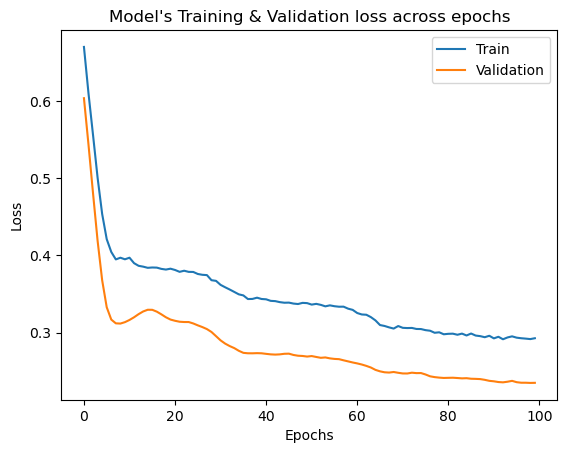

In [161]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

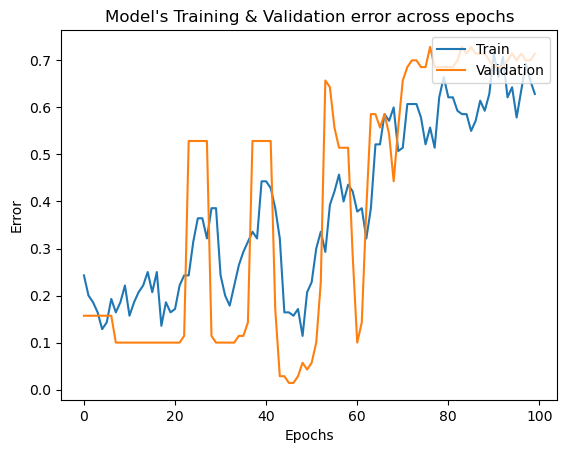

In [162]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model's Training & Validation error across epochs")
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [163]:
def get_recommendations(food, similarity_matrix = encoded_product_features, data = product):  
    # Get the index of the given food
    idx = data.index[data['product']==food][0]
    
    # Get the cosine similarity scores between the given food and all other foods
    sim_scores = similarity_matrix[idx]
    
    # Get indices of top 10 foods based on similarity scores
    top_indices = np.argsort(sim_scores)[::-1][:5]
    
    # Get recommended foods from data based on top indices
    recommended_foods = data.iloc[top_indices]
    
    return recommended_foods['product'].tolist()





In [164]:
recommended_foods = get_recommendations('strawberry')
print(recommended_foods)

['walnut', 'pappardelle pasta', 'dried cranberries', 'red wine vinegar', 'tomato sauce']
